# Implement and train a LSTM for sentiment analysis

## Step 0: set up the environment

In [1]:
import functools
import sys
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import tqdm
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Set the random seeds.
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
# Constance hyperparameters. 
# They have been tested and don't need to be tuned.
PAD_INDEX = 0
UNK_INDEX = 1
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
STOP_WORDS = set(stopwords.words('english'))
MAX_LENGTH = 256
BATCH_SIZE = 16
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
OUTPUT_DIM = 2
N_LAYERS = 3
DROPOUT_RATE = 0.1
LR = 3e-4
N_EPOCHS = 5

## Q(a): Implement your own data loader function.  
Q: Implement your own data loader function.  
First, you need to read the data from the dataset file on the local disk. 
You can leverage the train_test_split function from sklearn.model_selection. If you want to reproduce the same result every round, remember to set the random_state argument in train_test_split as a constant value.  
Finally return x_train, x_valid, x_test, y_train, y_valid, y_test where x represents reviews and y represent labels.   

In [4]:
def load_imdb(base_csv:str = './IMDBDataset.csv'):
    """
    Load the IMDB dataset
    :param base_csv: the path of the dataset file.
    :return: train, validation and test set.
    """
    # Add your code here.
    imdb_data = pd.read_csv(base_csv)
    train_validation_data, test_data = train_test_split(imdb_data, 
                                                        test_size = 0.2, 
                                                        train_size = 0.8, 
                                                        random_state = seed)
    train_data, validation_data = train_test_split(train_validation_data, 
                                                   test_size = 0.125, 
                                                   train_size = 0.875, 
                                                   random_state = seed)
    x_train =      train_data['review'].to_numpy()
    x_valid = validation_data['review'].to_numpy()
    x_test  =       test_data['review'].to_numpy()
    y_train =      train_data['sentiment'].to_numpy()
    y_valid = validation_data['sentiment'].to_numpy()
    y_test  =       test_data['sentiment'].to_numpy()
    
    print(f'shape of train data is {x_train.shape}')
    print(f'shape of test data is {x_test.shape}')
    print(f'shape of valid data is {x_valid.shape}')
    return x_train, x_valid, x_test, y_train, y_valid, y_test

# incremental testing
#xt1, xt2, xt3, yt1, yt2, yt3 = load_imdb()
#print(yt1.shape)
#print(yt2.shape)
#print(yt3.shape)

## Q(b): Implement the build_vocab function to build a vocabulary based on the training corpus
You should first compute the frequency of all the words in the training corpus.
Avoid the words that are in the STOP_WORDS. 
Filter the words by their frequency (>=min_freq).
Generate a corpus variable which contains a list of words.  

In [5]:
# My own function to split each review sentence
# into separate words
def split_sentence_into_words (review_sentence) :
    split_by_blank = []
    all_lower_cases = []
    
    split_by_blank = review_sentence.split()
    for each_word in split_by_blank :
        all_lower_cases.append(each_word.lower())
    
    return all_lower_cases

In [6]:

def build_vocab(x_train:list, min_freq:int = 5) -> dict:
    """
    build a vocabulary based on the training corpus.
    :param x_train:  List. The training corpus. 
    Each sample in the list is a string of text.
    :param min_freq: Int. The frequency threshold for selecting words.
    :return: dictionary {word:index}
    """
    # Add your code here. Your code should assign corpus with a list of words.
    corpus             = [] # placeholder
    x_train_text_words = []
    x_train_all_words  = []
    
    for text_string in x_train :
        x_train_text_words.append(split_sentence_into_words(text_string))
        
    for text_words in x_train_text_words :
        for word in text_words :
            if word not in STOP_WORDS :
                x_train_all_words.append(word)
    
    freq_count = Counter(x_train_all_words)
    for word in freq_count.keys() :
        if freq_count[word] >= min_freq :
            corpus.append(word)
    
    # Assign token index to each word in the vocabulary.
    vocab = {w:i+2 for i, w in enumerate(corpus)}
    vocab[PAD_TOKEN] = PAD_INDEX
    vocab[UNK_TOKEN] = UNK_INDEX

    return vocab

# incremental testing
#vocab_itest = build_vocab(xt1)
#print(len(vocab_itest))

## Q(c): Implement your tokenize function. 

For each word, find its index in the vocabulary. 
Return a list of int that represents the indices of words in the example. 

In [7]:
def tokenize(vocab: dict, example: str)-> list:
    """
    Tokenize the give example string into a list of token indices.
    :param vocab: dict, the vocabulary.
    :param example: a string of text.
    :return: a list of token indices.
    """
    token_indices_list = []
    
    string_to_words = split_sentence_into_words(example)
    
    for word in string_to_words :
        if word not in vocab.keys() :
            token_indices_list.append(vocab[UNK_TOKEN])
        else :
            token_indices_list.append(vocab[word])
            
    return token_indices_list

## Q(d): Implement the __getitem__ function.
Given an index i, you should return the i-th review
and label. The review is originally a string. Please tokenize it into a sequence of token indices.
Use the max_length parameter to truncate the sequence so that it contains at most max_length
tokens. Convert the label string (’positive’/’negative’) to a binary index. ’positive’ is 1 and ’negative’
is 0. Return a dictionary containing three keys: ’ids’, ’length’, ’label’ which represent the list
of token ids, the length of the sequence, the binary label.

In [8]:
class IMDB(Dataset):
    def __init__(self, x, y, vocab, max_length=256) -> None:
        """
        :param x: list of reviews
        :param y: list of labels
        :param vocab: vocabulary dictionary {word:index}.
        :param max_length: the maximum sequence length.
        """
        self.x = x
        self.y = y
        self.vocab = vocab
        self.max_length = max_length

    def __getitem__(self, idx: int):
        """
        Return the tokenized review and label by the given index.
        :param idx: index of the sample.
        :return: a dictionary containing three keys: 'ids', 'length', 'label' which 
        represent the list of token ids, the length of the sequence, the binary label.
        """
        # Add your code here.
        # pass  # placeholder
        return_dict = dict()
        token_indices_list = tokenize(self.vocab, self.x[idx])
        if len(token_indices_list) > self.max_length :
            truncate_list = token_indices_list[0:self.max_length]
        else :
            truncate_list = token_indices_list
        
        return_dict['ids']    = truncate_list
        return_dict['length'] = len(truncate_list)
        if self.y[idx] == 'positive' :
            return_dict['label'] = 1
        if self.y[idx] == 'negative' :
            return_dict['label'] = 0
        
        return return_dict
        
    def __len__(self) -> int:
        return len(self.x)

def collate(batch, pad_index):
    batch_ids = [torch.LongTensor(i['ids']) for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, 
                                          batch_first=True)
    batch_length = torch.Tensor([i['length'] for i in batch])
    batch_label = torch.LongTensor([i['label'] for i in batch])
    batch = {'ids': batch_ids, 'length': batch_length, 'label': batch_label}
    return batch

## Q(e):Implement the LSTM model for sentiment analysis.
Q(a): Implement the initialization function.
Write the initialization function. Your task is to create the model by stacking several
necessary layers including an embedding layer, a lstm cell, a linear layer, and a dropout layer.
You can call functions from Pytorch’s nn library. For example, nn.Embedding, nn.LSTM,
nn.Linear.<br>
Q(b): Implement the forward function.
   Write the forward function. Decide where to apply dropout. The sequences in the
batch have different lengths. Write/call a function to pad the sequences into the same length.
Apply a fully-connected (fc) layer to the output of the LSTM layer. Return the output features
which is of size [batch size, output dim].

In [9]:
# Call functions to pad the sequences into the same length
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [10]:
class LSTM(nn.Module):
    def __init__(self, vocab_size:int, embedding_dim:int, hidden_dim:int, 
                 output_dim:int, n_layers:int, 
                 dropout_rate:float, pad_index:int):
        """
        Create a LSTM model for classification.
        :param vocab_size: size of the vocabulary
        :param embedding_dim: dimension of embeddings
        :param hidden_dim: dimension of hidden features
        :param output_dim: dimension of the output layer 
        which equals to the number of labels.
        :param n_layers: number of layers.
        :param dropout_rate: dropout rate.
        :param pad_index: index of the padding token.
        """
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.
        self.embedding = nn.Embedding(num_embeddings = vocab_size, 
                                      embedding_dim  = embedding_dim, 
                                      padding_idx    = pad_index)
        self.lstm      = nn.LSTM(embedding_dim, hidden_dim, n_layers)
        self.fc        = nn.Linear(in_features  = hidden_dim, 
                                   out_features = output_dim)
        self.dropout   = nn.Dropout(p = dropout_rate)



    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        """
        Feed the given token ids to the model.
        :param ids: [batch size, seq len] batch of token ids.
        :param length: [batch size] batch of length of the token ids.
        :return: prediction of size [batch size, output dim].
        """
        # Add your code here.
        # pass  # placeholder.
        embedding_out   = self.embedding(ids)
        pack_padded_out = pack_padded_sequence(embedding_out, 
                                               length, 
                                               batch_first    = True, 
                                               enforce_sorted = False)
        lstm_out, (hidden_n_tensor, cell_n_tensor) = self.lstm(pack_padded_out)
        pad_packed_out, pad_packed_length = pad_packed_sequence(lstm_out, 
                                                                batch_first = True)
        out = self.dropout(hidden_n_tensor[-1])
        out = self.fc(out)
        
        return out

In [11]:
##Useful functions do not change
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def predict_sentiment(text, model, vocab, device):
        tokens = tokenize(vocab, text)
        ids = [vocab[t] if t in vocab else UNK_INDEX for t in tokens]
        length = torch.LongTensor([len(ids)])
        tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
        prediction = model(tensor, length).squeeze(dim=0)
        probability = torch.softmax(prediction, dim=-1)
        predicted_class = prediction.argmax(dim=-1).item()
        predicted_probability = probability[predicted_class].item()
        return predicted_class, predicted_probability



## Q(f):Train Your model
Copy the plotted figures of training/validation loss/accuracy
to your self-contained pdf report. What is your testing accuracy? (The provided code contains
the plot function and computation of test accuracy. You just need to report the value of testing
accuracy.)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 56590
The model has 16,066,562 trainable parameters
evaluating...: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 67.47it/s]
epoch: 1
train_loss: 0.585, train_acc: 0.676
valid_loss: 0.461, valid_acc: 0.786
evaluating...: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 68.06it/s]
epoch: 2
train_loss: 0.385, train_acc: 0.838
valid_loss: 0.403, valid_acc: 0.819
evaluating...: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 67.66it/s]
epoch: 3
train_loss: 0.267, train_acc: 0.895
valid_loss: 0.399, valid_acc: 0.828
evaluating...: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 67.38it/s]
epoch: 4
train_loss: 0.171, train_acc: 0.938
valid_loss: 0.423, valid_acc: 0.838
evaluating...: 100%|██████

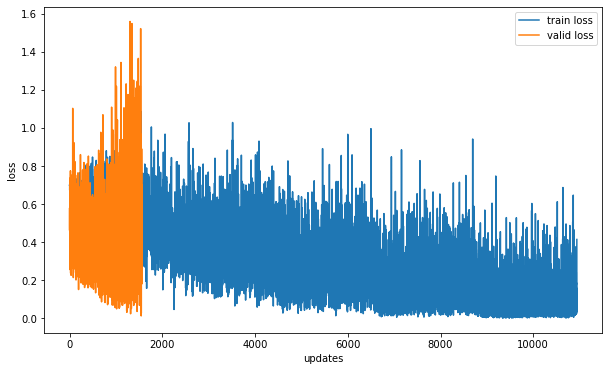

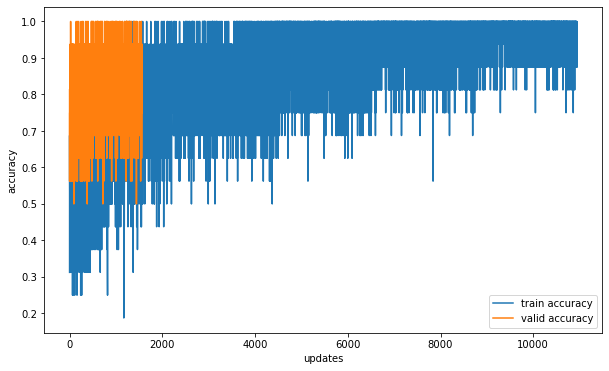

In [12]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()
vocab = build_vocab(x_train)
vocab_size = len(vocab)
print(f'Length of vocabulary is {vocab_size}')

train_data = IMDB(x_train, y_train, vocab, MAX_LENGTH)
valid_data = IMDB(x_valid, y_valid, vocab, MAX_LENGTH)
test_data = IMDB(x_test, y_test, vocab, MAX_LENGTH)

collate = functools.partial(collate, pad_index=PAD_INDEX)

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=BATCH_SIZE, 
                                               collate_fn=collate, 
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, 
                                               batch_size=BATCH_SIZE, 
                                               collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, 
                                              batch_size=BATCH_SIZE, 
                                              collate_fn=collate)

# Model
model = LSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 
             N_LAYERS, DROPOUT_RATE, PAD_INDEX)
print(f'The model has {count_parameters(model):,} trainable parameters')
model.apply(initialize_weights)

# Optimization
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

# Start training
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(train_dataloader, model, 
                                  criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    # Save the model that achieves the smallest validation loss.
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'lstm.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')


# Plot training and validation losses.
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

# Plot training and validation accuracies.
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy')


# Load the best model's weights.
model.load_state_dict(torch.load('lstm.pt'))

# Evaluate
test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)
print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

